In [16]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(2)

<h2 id="Model">1_Neural Network Module and Training Function</h2> 

<img src="https://ibm.box.com/shared/static/5wtclahun0f70qlwkn2kxzh3amnbq4zg.png" width="200" alt="Neural Network Model">


In [17]:
# Using relu activation function
class NetRelu(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        '''
        D_in = Total dimenstiom in the input layer
        H1 = Total neurons in the first hidden layer
        H2 = Total neurons in the second hidden layer
        D_out = Total output from from model
        '''
        super(NetRelu, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1,H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    # Predictions
    def forward(self, x):
        x = torch.relu(self.linear1(x)) # Hidden layer 1
        x = torch.relu(self.linear2(x)) # Hidden layer 2
        x = self.linear3(x) # Output layer
        return x

In [18]:
# Train the model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_accuracy': []}  
    
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
        
        correct = 0
        for x, y in validation_loader:
            z = model(x.view(-1, 28 * 28))
            _, label = torch.max(z, 1)
            correct += (label == y).sum().item()
    
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff, model

In [19]:
# Make some data
train_dataset = dsets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())

# Create the validating dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


# Create the training data loader and validation data loader object
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

In [20]:
# Define the model parameters
criterion = nn.CrossEntropyLoss()

# Set the parameters for create the model
input_dim = 28*28
hidden_dim1 = 50
hidden_dim2 = 50
output_dim = 10

# Set the epoch numbers
cust_epochs = 50

learning_rate = 0.01

In [21]:
# Train the model

modelRelu = NetRelu(input_dim, hidden_dim1, hidden_dim2, output_dim)
optimizer = torch.optim.SGD(modelRelu.parameters(), lr = learning_rate)
training_results_relu, model = train(modelRelu, criterion, train_loader, validation_loader, optimizer, epochs = cust_epochs)

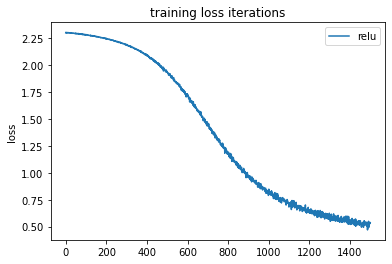

In [22]:
# Compare the training loss
plt.plot(training_results_relu['training_loss'], label='relu')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.legend()

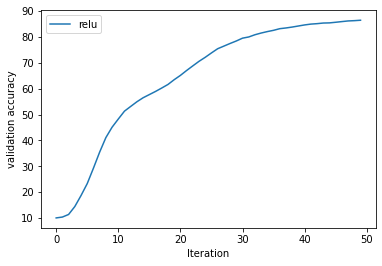

In [23]:
plt.plot(training_results_relu['validation_accuracy'], label = 'relu') 
plt.ylabel('validation accuracy')
plt.xlabel('Iteration')   
plt.legend()

<h1>2_Deeper Neural Networks with nn.ModuleList()</h1>

Lets say we want to try even more deeper NN, we can do this dynamically using nn.ModuleList() functionality.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

In [37]:
# Define the function to plot the diagram

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

In [40]:
# Create Data Class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

<h2 id="Model">3_Neural Network Module and Function for Training</h2>

Neural Network Module using <code>ModuleList()</code>

In [64]:
class Net(nn.Module):
    
    # Constructor:
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size)) # builds linear models on different hidden layers
            
    # Prediction 
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l<L-1:
                activation = F.relu(linear_transform(activation)) # relu in hidden layers
            else:
                activation = linear_transform(activation) # Linear function in last layer
        return activation
    
    
# Define the function for training the model
def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            LOSS.append(loss.item())
        ACC.append(accuracy(model, data_set))
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return LOSS

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x),1)
    return (yhat==data_set.y).numpy().mean()

**Train and Validate the Model**

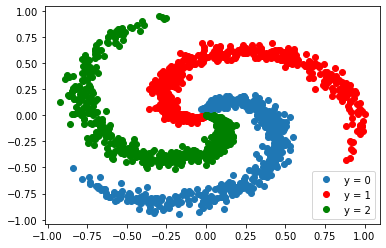

In [67]:
# Create the dataset object

data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)

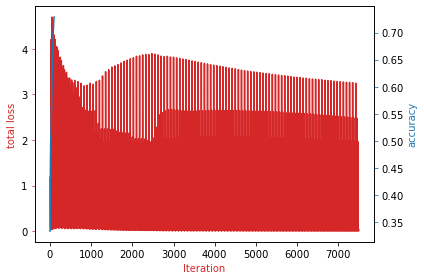

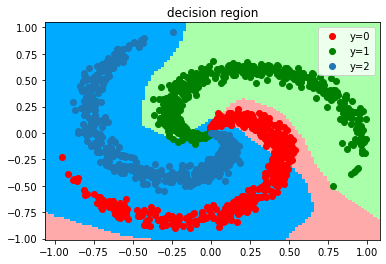

In [44]:
# Training the model with 1 hidden layer with 50 neurons

Layers = [2,50,3]
model = Net(Layers)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 100)

plot_decision_regions_3class(model, data_set)

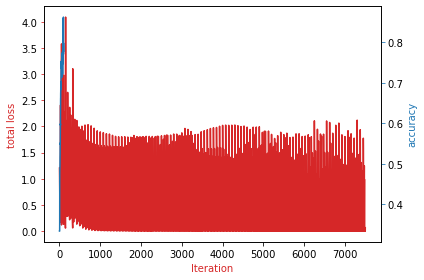

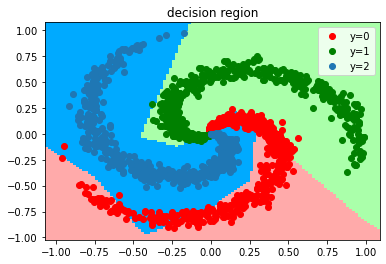

In [48]:
# Create a network with 2 hidden layers with 20 neurons in total

# Training the model with 1 hidden layer with 50 neurons

Layers = [2,10,10, 3]
model = Net(Layers)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 100)

plot_decision_regions_3class(model, data_set)

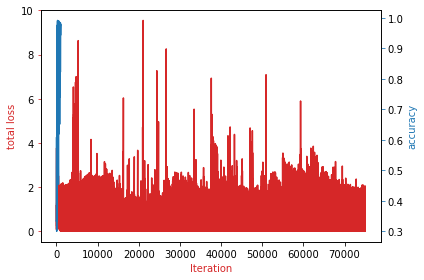

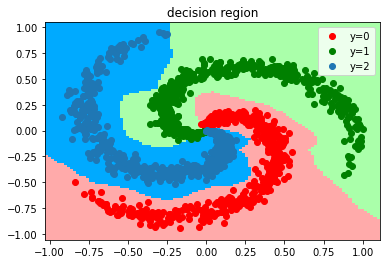

In [68]:
# Create a network with 3 hidden layers with 20 neurons in total

# Training the model with 1 hidden layer with 50 neurons

Layers = [2,20,20,20,3]
model = Net(Layers)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 1000)

plot_decision_regions_3class(model, data_set)

# 4_Dropout Regularization:

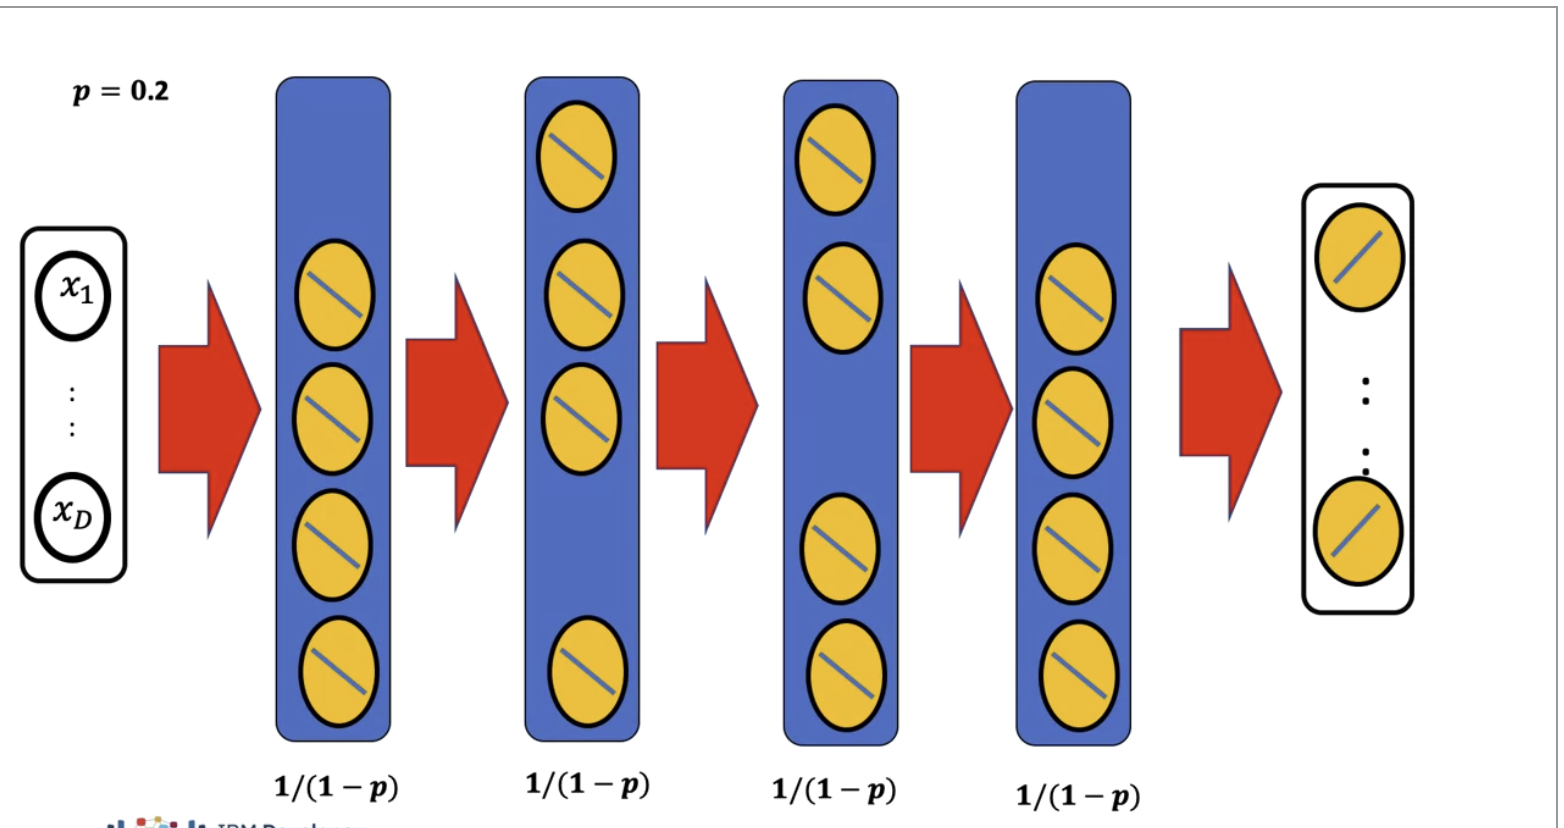

**Ideal Scenario:**

With hidden layer with less number of neurons we use small value of p nearby to 0.05 to 0.1 and for hidden layer with more number of neurons we use value slightly higher value of p somewhere around 0.5

**Note: p is the probability of dropping a neuron**

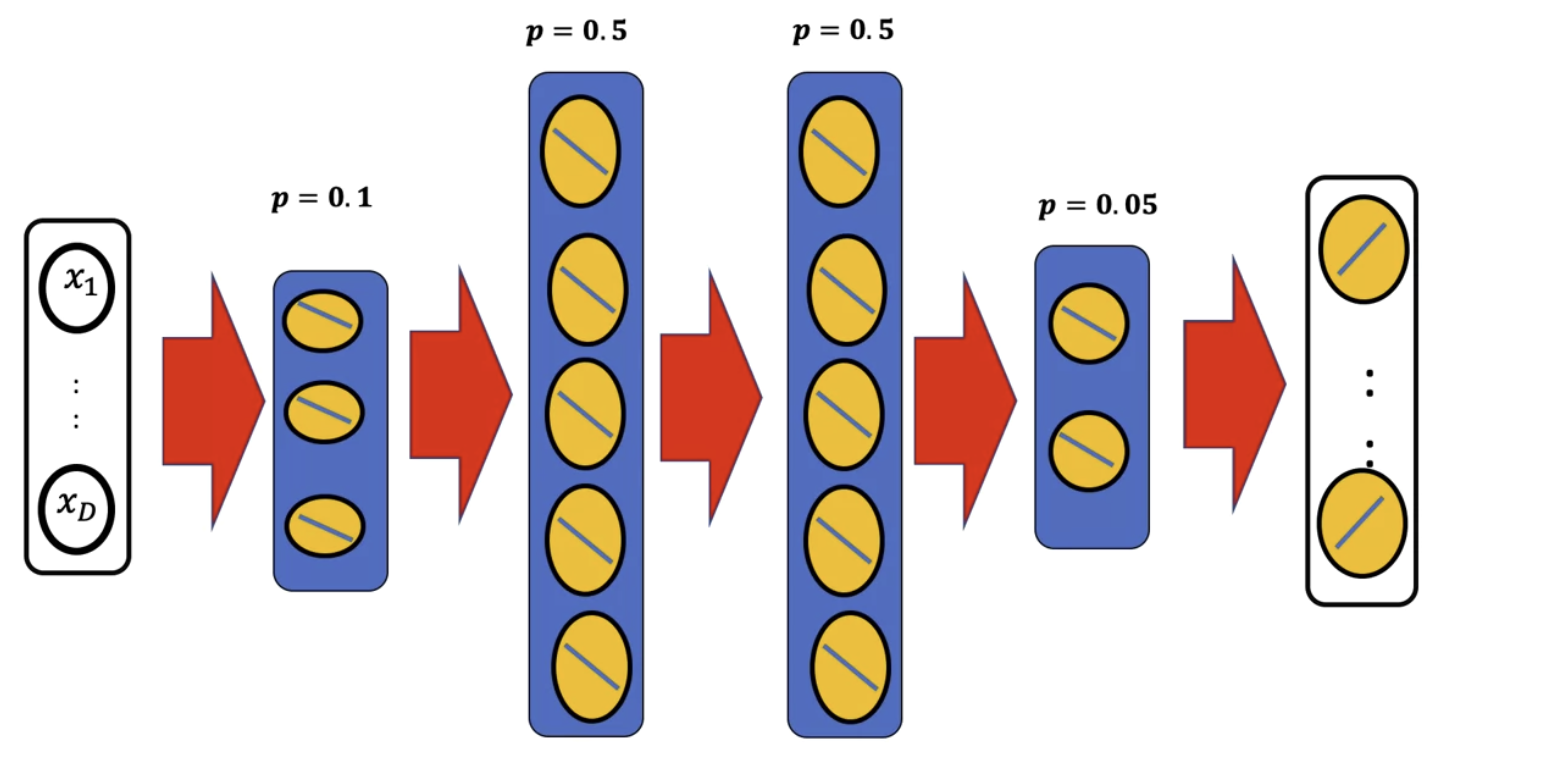

In [85]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [101]:
# The function for plotting the diagram

def plot_decision_regions_3class(data_set, model=None):
    cmap_light = ListedColormap([ '#0000FF','#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]
    
    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    if model != None:
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light) 

    plt.title("decision region vs True decision boundary")
    
    
# The function for calculating accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

**Make some data:**

In [102]:
# Create data class for creating dataset object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        
    # Getter        
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

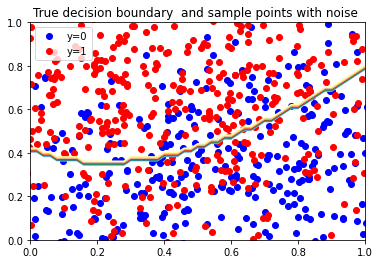

In [103]:
# Create a dataset object

data_set = Data(noise_std=0.2)
data_set.plot()

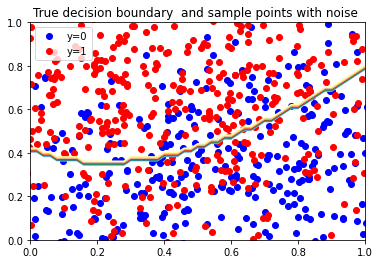

In [104]:
# Get some validation data

torch.manual_seed(0) 
validation_set = Data(train=False)
data_set.plot()

<h2 id="Model_Cost">Create the Model, Optimizer, and Total Loss Function (Cost)</h2>


Create a custom module with three layers. <code>in_size</code> is the size of the input features, <code>n_hidden</code> is the size of the layers, and <code>out_size</code> is the size. <code>p</code> is the dropout probability. The default is 0, that is, no dropout.


In [105]:
class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden, out_size,p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p) # initialize dropout
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        
    # Prediction
    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x))) # Applying dropout to hidden layer 1
        x = F.relu(self.drop(self.linear2(x))) # Applying dropout to hidden layer 2
        x = self.linear3(x)
        return x

In [106]:
# Creating two models : with and without dropout (p=0.5)
model = Net(2,300,2)
model_drop = Net(2,300,2,p=0.5)

# Set the model to training mode
model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)

Train the model by using the Adam optimizer. 

In [107]:
# Set the optimizer function and criterion functions
optimizer_ofit = torch.optim.Adam(model.parameters(), lr = 0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()

In [108]:
# Model train function

def train_model(epochs):
    LOSS = {}
    LOSS['training data no dropout'] = []
    LOSS['validation data no dropout'] = []
    LOSS['training data dropout'] = []
    LOSS['validation data dropout'] = []
    
    for epoch in range(epochs):
        # All sample used for training in this case
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)
        
        # Store the loss for both the training and validation data for both the models
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()
        
        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()
        
    return LOSS

In [109]:
# Define epochs and train

epochs = 500
LOSS = train_model(epochs)

In [110]:
# Set the model to evaluation model
model_drop.eval()

# Print the accuracy of the model without dropout
print("Accuracy without dropout", accuracy(model, validation_set))

# Print the accuracy of the model with dropout
print("Accuracy with dropout", accuracy(model_drop, validation_set))

Accuracy without dropout 0.792
Accuracy with dropout 0.856


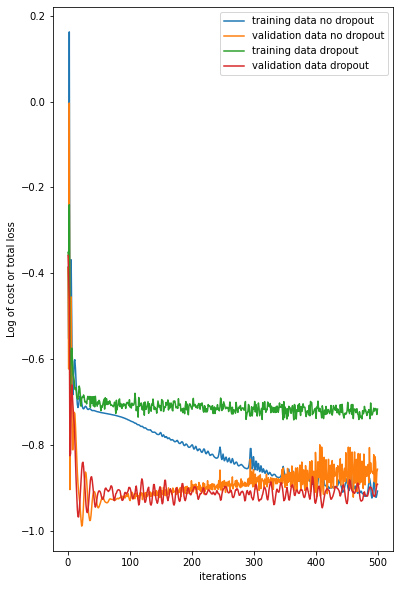

In [111]:
# Plot the LOSS

plt.figure(figsize=(6.1, 10))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()

You see that the model without dropout performs better on the training data, but it performs worse on the validation data. This suggests overfitting.  However, the model using dropout performed better on the validation data, but worse on the training data. 